In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import initializers
from transformers import pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import keras_nlp
import pathlib
import random
import string
import re
import os

Part 1: GAN

In [343]:
loss = 'binary_crossentropy'
np.random.seed(1000)

In [377]:
(x_train, _), (_, _) = fashion_mnist.load_data()
print(x_train.shape)
num_of_images, N, n = 10, x_train.shape[0], x_train.shape[1]
input_dim, latent_dim = n**2, 100

(60000, 28, 28)


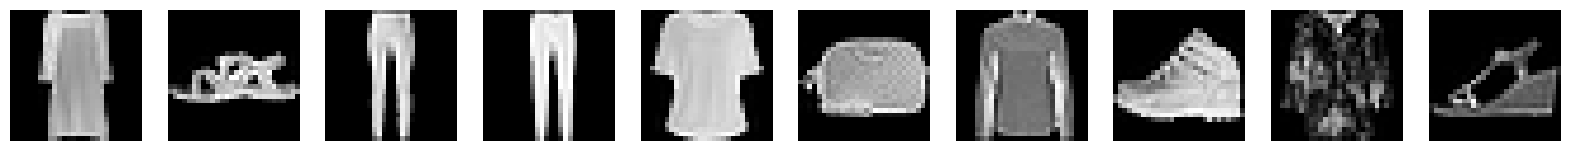

In [378]:
plt.figure(figsize = (20, 5))
for i in range(num_of_images):
    plt.subplot(1, num_of_images, i + 1)
    plt.imshow(x_train[np.random.randint(0, N)])
    plt.gray()
    plt.axis('off')
plt.show()

In [379]:
x_train = x_train.reshape(x_train.shape[0], input_dim)
x_train = (x_train.astype(np.float32) - 127.5)/127.5  

In [359]:
discriminator = keras.Sequential()

discriminator.add(layers.Dense(1024, input_dim = input_dim, kernel_initializer = initializers.RandomNormal()))
discriminator.add(layers.LeakyReLU(0.1))
discriminator.add(layers.Dropout(0.5))
        
discriminator.add(layers.Dense(512))
discriminator.add(layers.LeakyReLU(0.1))
discriminator.add(layers.Dropout(0.5))
    
discriminator.add(layers.Dense(256))
discriminator.add(layers.LeakyReLU(0.1))
discriminator.add(layers.Dropout(0.5))

discriminator.add(layers.Dense(1, activation = 'sigmoid'))

In [360]:
generator =  keras.Sequential()

generator.add(layers.Dense(256, input_dim = latent_dim, kernel_initializer = initializers.RandomNormal()))
generator.add(layers.LeakyReLU(0.1))
    
generator.add(layers.Dense(512))
generator.add(layers.LeakyReLU(0.1))
    
generator.add(layers.Dense(1024))
generator.add(layers.LeakyReLU(0.1))
    
generator.add(layers.Dense(input_dim, activation = 'tanh'))

In [388]:
discriminator.compile(loss = loss, optimizer = 'adam')
discriminator.trainable = False

generator.compile(loss = loss, optimizer = 'adam')

gan_input = keras.Input(shape = (latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = keras.Model(inputs = gan_input, outputs = gan_output)

gan.compile(loss = loss, optimizer = 'adam')

In [389]:
def noise(x, y):
    return np.random.normal(0, 1, [x, y])

In [390]:
def plot_generated_images(epoch, generator):
    generated_images = generator.predict(noise(num_of_images, latent_dim)).reshape(num_of_images, n, n)
    plt.figure(figsize = (20, 5))
    for i in range(num_of_images):
        plt.subplot(1, num_of_images, i + 1)
        plt.imshow(generated_images[i])
        plt.gray()
        plt.axis('off')
    plt.show()

In [391]:
discrim_losses = []

In [392]:
def train_model(epochs, batch_size):
    for epoch in range(epochs + 1):
        for _ in range(num_batches):
            image_batch = x_train[np.random.randint(0, N, batch_size)]
            generated_images = generator.predict(noise(batch_size, latent_dim), verbose = 0)
            y_dis, y_gen = np.array([0.9]*batch_size + [0]*batch_size), np.ones(batch_size)
            discriminator.trainable = True
            losses = discriminator.train_on_batch(np.concatenate([image_batch, generated_images]), y_dis)
            discrim_losses.append(losses)
            discriminator.trainable = False
            gan.train_on_batch(noise(batch_size, latent_dim), y_gen)
        if epoch%10 == 0:
            print(f'epoch: {epoch}')
            plot_generated_images(epoch, generator)

epoch:  0
1/1 [==============================] - 0s 71ms/step


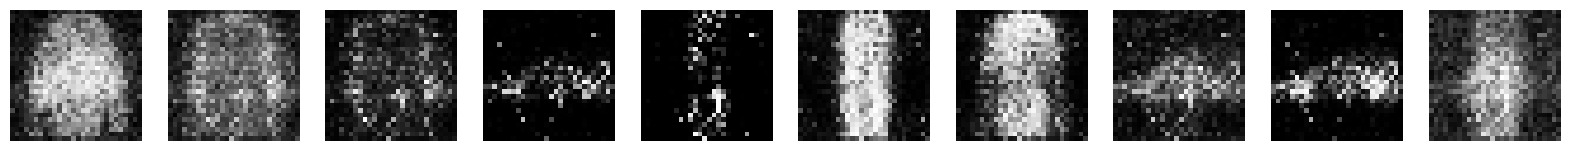

epoch:  10
1/1 [==============================] - 0s 36ms/step


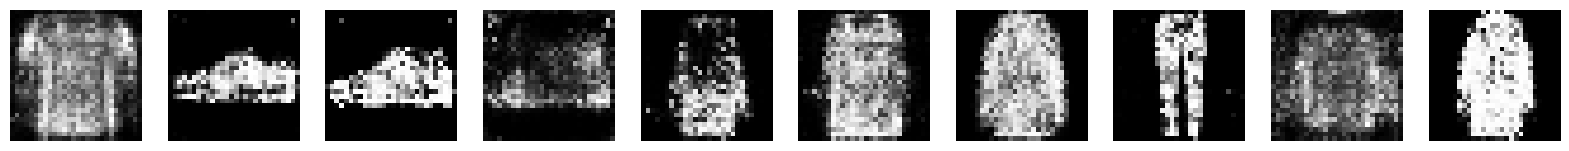

epoch:  20
1/1 [==============================] - 0s 49ms/step


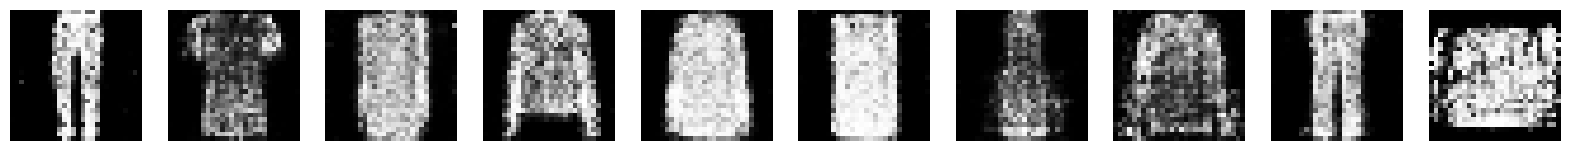

epoch:  30
1/1 [==============================] - 0s 156ms/step


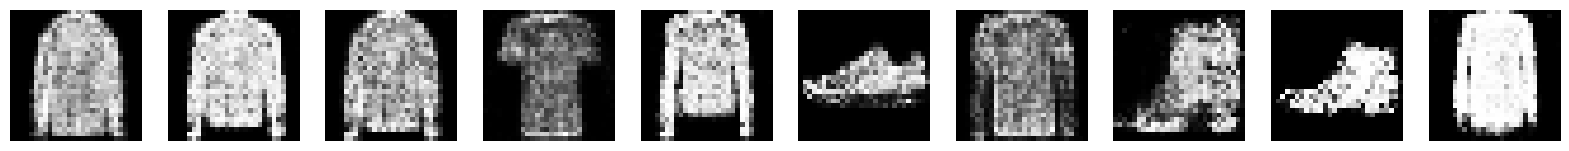

epoch:  40
1/1 [==============================] - 0s 223ms/step


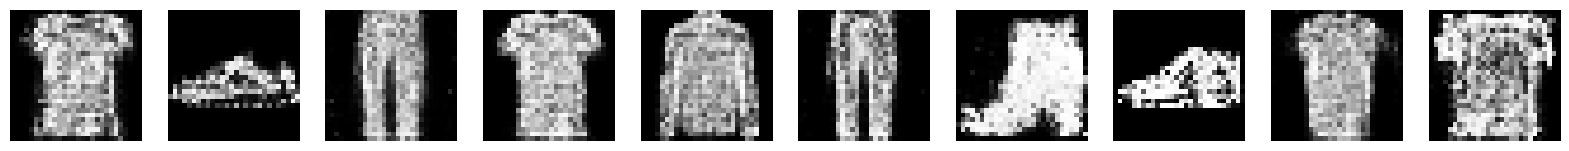

epoch:  50
1/1 [==============================] - 1s 613ms/step


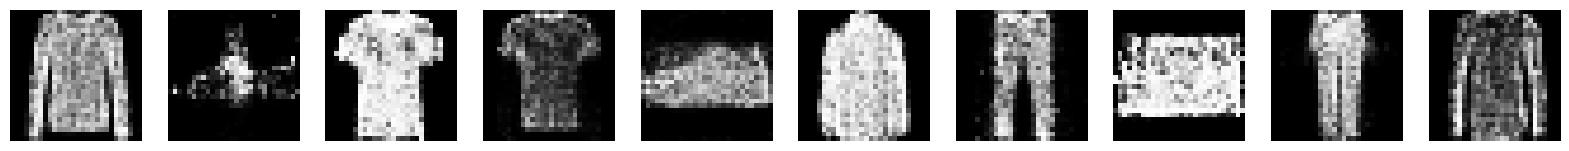

In [393]:
epochs, batch_size = 50, 128
num_batches = N//batch_size
train_model(epochs, batch_size)

Text(0, 0.5, 'Losses')

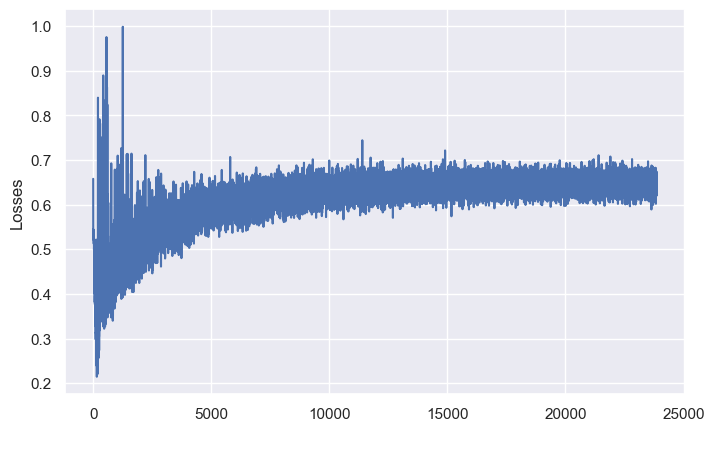

In [415]:
sns.set(style = 'darkgrid')
plt.subplots(figsize = (8, 5))
plt.plot(discrim_losses)
plt.xlabel(' ')
plt.ylabel('Losses')

Part 2: English-Ukrainian translator with a sequence-to-sequence Transformer

In [82]:
ukr_alphabet = 'абвгґдеєжзиіїйклимнопрстуфхцчшщьюя'
tokens = ['[PAD]', '[UNK]', '[START]', '[END]']

In [83]:
file = open('ukr-eng/ukr.txt', encoding = 'utf-8')
data = file.readlines()
file.close()

In [84]:
eng = [line[:line.index('\t')].lower() for line in data]
ukr = [line[line.index('\t') + 1:line.index('CC-BY') - 1].lower() for line in data]
eng = [re.sub(f'[^{string.ascii_lowercase + string.digits + string.whitespace}]', '', sent) for sent in eng]
ukr = [re.sub(f'[^{ukr_alphabet + string.digits + string.whitespace}]', '', sent) for sent in ukr]

In [85]:
eng[-1], ukr[-1]

('ive heard that you should never date anyone who is less than half your age plus seven tom is now 30 years old and mary is 17 how many years will tom need to wait until he can start dating mary',
 'я чула що не слід зустрічатися з кимось кому менше половини твоїх років плюс сім тому зараз 30 років а мері 17 скільки років потрібно почекати тому допоки він може почати зустрічатися з мері')

In [86]:
pairs = [(eng[i], ukr[i]) for i in range(len(eng))]

In [87]:
random.shuffle(pairs)
train_pairs = pairs[:int(0.75*len(pairs))]
test_valid_pairs = list(set(pairs) - set(train_pairs))
test_pairs, valid_pairs = test_valid_pairs[:len(test_valid_pairs)//2], test_valid_pairs[len(test_valid_pairs)//2:]

In [88]:
print(f'train set: {len(train_pairs)} pairs')
print(f'test set: {len(test_pairs)} pairs')
print(f'validation set: {len(valid_pairs)} pairs')

train set: 117129 pairs
test set: 19448 pairs
validation set: 19449 pairs


In [89]:
train_eng, train_ukr = [pair[0] for pair in train_pairs], [pair[1] for pair in train_pairs]
test_eng, test_ukr = [pair[0] for pair in test_pairs], [pair[1] for pair in test_pairs]
valid_eng, valid_ukr = [pair[0] for pair in valid_pairs], [pair[1] for pair in valid_pairs]

In [90]:
tf_train_eng = tf.data.Dataset.from_tensor_slices(train_eng).batch(1000).prefetch(2)
tf_train_ukr = tf.data.Dataset.from_tensor_slices(train_ukr).batch(1000).prefetch(2)

In [91]:
eng_vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(tf_train_eng, 20000, reserved_tokens = tokens)
ukr_vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(tf_train_ukr, 20000, reserved_tokens = tokens)

In [92]:
print(eng_vocab[50:75])
print(ukr_vocab[50:75])

['was', 'he', 'mary', 'me', 'in', 'it', 'this', 'are', 'my', 'what', 'did', 'your', 'know', 'of', 'be', 'for', 'we', 'not', 'like', 'want', 'with', 'think', 'on', 'didnt', 'youre']
['це', 'ти', 'на', 'ви', 'мені', 'мері', 'тома', 'він', 'ми', 'мене', 'тому', 'до', 'дуже', 'сказав', 'як', 'зробити', 'чому', 'тобі', 'тебе', 'цього', 'ще', 'за', 'вона', 'щоб', 'був']


In [93]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(eng_vocab)
ukr_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(ukr_vocab)
id_eng_tokens = [eng_tokenizer.token_to_id(token) for token in tokens]
id_ukr_tokens = [ukr_tokenizer.token_to_id(token) for token in tokens]

In [94]:
def preprocess_batch(eng, ukr):
    eng, ukr = eng_tokenizer(eng), ukr_tokenizer(ukr)
    eng_sep = keras_nlp.layers.StartEndPacker(20, pad_value = id_eng_tokens[0])
    ukr_sep = keras_nlp.layers.StartEndPacker(21, id_ukr_tokens[2], id_ukr_tokens[3], id_ukr_tokens[0])
    eng, ukr = eng_sep(eng), ukr_sep(ukr)
    return {'encoder_inputs': eng, 'decoder_inputs': ukr[:, :-1]}, ukr[:, 1:]

In [95]:
train_ds = tf.data.Dataset.from_tensor_slices((train_eng, train_ukr)).batch(64).map(preprocess_batch, tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_eng, valid_ukr)).batch(64).map(preprocess_batch, tf.data.AUTOTUNE)
train_ds, valid_ds = train_ds.shuffle(2048).prefetch(16).cache(), valid_ds.shuffle(2048).prefetch(16).cache()

In [101]:
encoder_inputs = keras.Input((None, ), None, 'encoder_inputs', 'int64')
x = keras_nlp.layers.TokenAndPositionEmbedding(10000, 20, 256, mask_zero = True)(encoder_inputs)
encoder_outputs = keras_nlp.layers.TransformerEncoder(2048, 8)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input((None, ), None, 'decoder_inputs', 'int64')
encoded_seq_inputs = keras.Input((None, 256), None, 'decoder_state_inputs')
x = keras_nlp.layers.TokenAndPositionEmbedding(10000, 20, 256, mask_zero = True)(decoder_inputs)
x = keras_nlp.layers.TransformerDecoder(2048, 8)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
decoder_outputs = keras.layers.Dense(10000, activation = 'softmax')(keras.layers.Dropout(0.5)(x))
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name = 'transformer')

In [102]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_2  (None, None, 256)   2565120     ['encoder_inputs[0][0]']         
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   1315072     ['token_and_position_em

In [103]:
transformer.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
transformer.fit(train_ds, epochs = 5, validation_data = valid_ds)

Epoch 1/5
1831/1831 [==============================] - 1119s 609ms/step - loss: 1.6867 - accuracy: 0.4129 - val_loss: 1.4193 - val_accuracy: 0.4831
Epoch 2/5
1831/1831 [==============================] - 1074s 587ms/step - loss: 1.3676 - accuracy: 0.5069 - val_loss: 1.2386 - val_accuracy: 0.5334
Epoch 3/5
1831/1831 [==============================] - 1072s 586ms/step - loss: 1.2175 - accuracy: 0.5463 - val_loss: 1.1497 - val_accuracy: 0.5610
Epoch 4/5
1831/1831 [==============================] - 1121s 613ms/step - loss: 1.1388 - accuracy: 0.5710 - val_loss: 1.1008 - val_accuracy: 0.5807
Epoch 5/5
1831/1831 [==============================] - 1100s 601ms/step - loss: 1.0968 - accuracy: 0.5887 - val_loss: 1.0791 - val_accuracy: 0.5914


In [116]:
def decode_sequence(input_sentences):
    
    def token_probability_fn(decoder_input_tokens):
        return transformer([encoder_input_tokens, decoder_input_tokens])[:, -1, :]
    
    prompt = tf.fill((tf.shape(input_sentences)[0], 1), id_ukr_tokens[2])
    encoder_input_tokens = eng_tokenizer(input_sentences).to_tensor(shape = (None, 20))
    generated_tokens = keras_nlp.utils.top_p_search(token_probability_fn, prompt, 20, 0.1, end_token_id = id_ukr_tokens[3])
    return ukr_tokenizer.detokenize(generated_tokens)

In [115]:
for i in range(5):
    input_sentence = random.choice(test_eng)
    translated_sentence = decode_sequence(tf.constant([input_sentence])).numpy()[0].decode('utf-8')
    for token in tokens:
        translated_sentence = translated_sentence.replace(token, '')
    print(f'{i + 1}) ' + input_sentence + ' --> ' + translated_sentence)

1) did you tell the truth -->  ти сказав правду                
2) tom does whatever mary tells him to do -->  том зробить все що він йому каже            
3) tom will sing for mary -->  том на нас співати для мері             
4) tom wants you to help him today -->  том хоче щоб ти йому сьогодні йому допоміг           
5) please translate this into french -->  будь ласка у цьому французьку              


Part 3: experiments with Pipelines 

In [2]:
question_answering = pipeline('question-answering')
text_generation = pipeline('text-generation')

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at distilbert-base-cased-distilled-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.
No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint

In [50]:
generated_text = text_generation('What does it')[0]['generated_text']
generated_text = generated_text.replace('\n', '')

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [51]:
question = generated_text[:generated_text.index('?') + 1]
context = generated_text[generated_text.index('?') + 1: -generated_text[::-1].index('.')]

In [52]:
print('question: ', question)
print('context: ', context)

question:  What does it mean to be "an actor"?
context:   You'd be hard-pressed to find more "an act" to say about acting than the act of making love to someone. In other words, it means a certain amount of effort.


In [53]:
answer = question_answering(question = question, context = context)

In [54]:
print('question: ', question) 
print('answer: ', answer['answer'])
print('score: ', answer['score'])

question:  What does it mean to be "an actor"?
answer:  a certain amount of effort
score:  0.5633123517036438


In [55]:
image_classification = pipeline('image-classification')

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 5dca96d (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at google/vit-base-patch16-224.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [56]:
tomatoes = [Image.open('train/tomatoes/' + file) for file in os.listdir('train/tomatoes')]
apples = [Image.open('train/apples/' + file) for file in os.listdir('train/apples')]

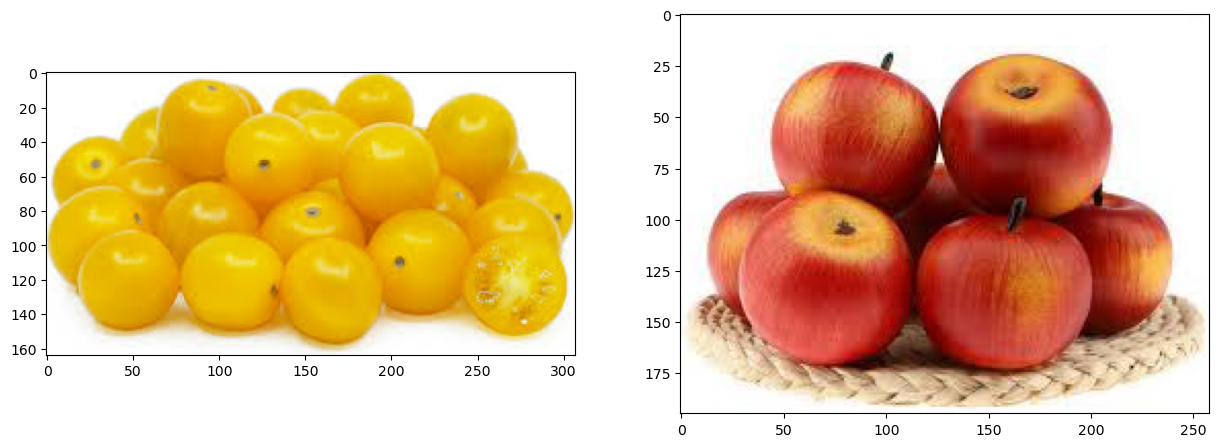

In [79]:
plt.subplots(figsize = (15, 10))
plt.subplot(1, 2, 1)
n_1 = random.choice(range(len(tomatoes)))
plt.imshow(tomatoes[n_1])
plt.subplot(1, 2, 2)
n_2 = random.choice(range(len(apples)))
plt.imshow(apples[n_2])
plt.show()

In [80]:
image_classification(tomatoes[n_1])

[{'score': 0.2652934193611145, 'label': 'corn'},
 {'score': 0.13062384724617004, 'label': 'ear, spike, capitulum'},
 {'score': 0.07076896727085114, 'label': 'lemon'},
 {'score': 0.05796116217970848, 'label': 'bell pepper'},
 {'score': 0.020111022517085075, 'label': 'spaghetti squash'}]

In [81]:
image_classification(apples[n_2])

[{'score': 0.536524772644043, 'label': 'Granny Smith'},
 {'score': 0.07475331425666809, 'label': 'hamper'},
 {'score': 0.045536719262599945, 'label': 'orange'},
 {'score': 0.040097426623106, 'label': 'shopping basket'},
 {'score': 0.039609212428331375, 'label': 'banana'}]